In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [340]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})


df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')


df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)

(113472, 4)


In [341]:
# Define the morning hour range
start_hour = 6
end_hour = 21

# Filter rows based on morning hour range
df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
print(df.shape)

(70920, 4)


In [342]:
#Filtering cutailment period
# Define window size (number of hours in the sliding window)
window_size = 4

# Function to check if all values in the window are the same
def is_constant(window):
    return np.all(window == window[0])

# Identify curtailment periods using a rolling window
df['curtailment'] = df['Power'].rolling(window=window_size, min_periods=1).apply(is_constant)

# Convert rolling result to boolean (1.0 for curtailment, 0.0 for non-curtailment)
df['curtailment'] = df['curtailment'] == 1.0

# Filter out curtailment periods
df = df[~df['curtailment']]
print(df.shape)

(52940, 5)


In [333]:
df = df[df['POA']>100]
print(df.shape)

(26304, 5)


In [ ]:
'''
# Rolling statistics
window_size = 5
df['rolling_mean_POA'] = df['POA'].rolling(window=window_size, center=True).mean()
df['rolling_std_POA'] = df['POA'].rolling(window=window_size, center=True).std()

df['rolling_mean_Power'] = df['Power'].rolling(window=window_size, center=True).mean()
df['rolling_std_Power'] = df['Power'].rolling(window=window_size, center=True).std()

# Filtering outliers using IQA
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for power output and irradiance
Q1_Power = df['Power'].quantile(0.25)
Q3_Power = df['Power'].quantile(0.75)
IQR_Power = Q3_Power - Q1_Power

Q1_POA = df['POA'].quantile(0.25)
Q3_POA = df['POA'].quantile(0.75)
IQR_POA = Q3_POA - Q1_POA

# Define lower and upper bounds for filtering
lower_bound_Power = Q1_Power - 1.5 * IQR_Power
upper_bound_Power = Q3_Power + 1.5 * IQR_Power

lower_bound_POA = Q1_POA - 1.5 * IQR_POA
upper_bound_POA = Q3_POA + 1.5 * IQR_POA

# Filter out data points outside the bounds
df = df[
    (df['Power'] >= lower_bound_Power) & (df['Power'] <= upper_bound_Power) &
    (df['POA'] >= lower_bound_POA) & (df['POA'] <= upper_bound_POA)
]

print(df.shape)
'''

# Identify outliers using roling mean
#deviation_threshold = 2  # 2 standard deviations
#df_filtered = df[
#    (df['Power'] >= df['rolling_mean_Power'] - deviation_threshold * df['rolling_std_Power']) &
#    (df['Power'] <= df['rolling_mean_Power'] + deviation_threshold * df['rolling_std_Power']) &
#    (df['POA'] >= df['rolling_mean_POA'] - deviation_threshold * df['rolling_std_POA']) &
#    (df['POA'] <= df['rolling_mean_POA'] + deviation_threshold * df['rolling_std_POA'])
#]
#
#print(df.shape)

In [237]:
#from sklearn.impute import KNNImputer
# Create a KNN imputer object
#original_index = df.index

# Select columns to impute
#columns_to_impute = ['Power','POA', 'Tmod']

# Create a KNN imputer object
#knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform only the selected columns
#df_imputed_values = knn_imputer.fit_transform(df[columns_to_impute])

# Convert the result back to a DataFrame and restore the original index
#df = pd.DataFrame(df_imputed_values, columns=columns_to_impute, index=original_index)


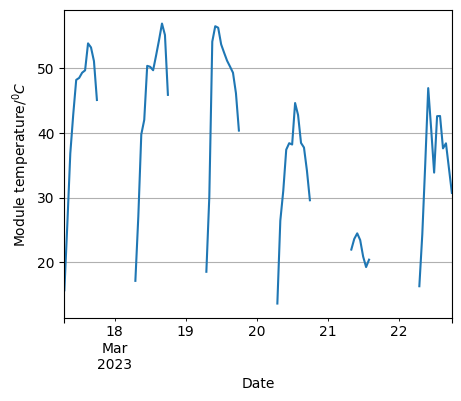

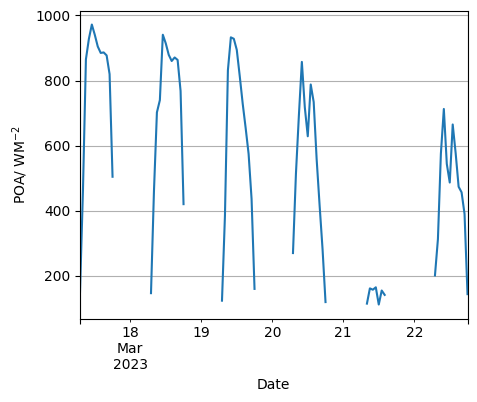

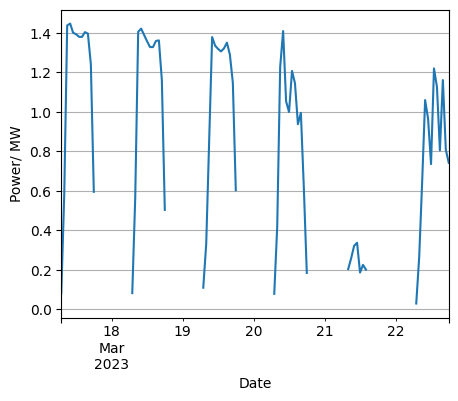

In [334]:
# Define the period you want to plot
start_date = '2023-03-17'
end_date = '2023-03-22'

# Slice the DataFrame based on the specified period
df_period = df[start_date:end_date]

df_period['Tmod'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Module temperature/$^{0}C$ ')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['POA'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('POA/ WM$^{-2}$')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['Power'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [335]:
df.shape

(26304, 5)

In [336]:
df.describe()

,Power,POA,Tmod,Temp
count,26304.000000,26304.000000,26304.000000,26304.000000
mean,0.832680,606.398722,33.056311,19.806797
std,0.530876,311.708168,12.280679,13.311813
min,0.000000,100.339200,-2.713566,0.000000
25%,0.347773,313.064700,23.923060,14.400000
50%,0.906647,629.982400,32.767650,18.600000
75%,1.293348,839.994600,42.064920,24.900000
max,1.700452,1502.591000,68.853870,655.060000


In [338]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = '2023-03-17'
end_date = '2023-03-22'

temp = df[start_date:end_date][['Power']].resample('15min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
temp_cleaned = temp.dropna()

data = temp_cleaned.values
print(data.shape)

True
False
(232, 1)


True
False
(2318,)
Shape of the sequences array: (2314, 5, 1)
Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 lstm_99 (LSTM)              (None, 128)                  66560     ['input_49[0][0]']            
                                                                                                  
 dense_194 (Dense)           (None, 128)                  16512     ['lstm_99[0][0]']             
                                                                                                  
 dense_195 (Dense)           (None, 2)                    258       ['dense_194[0][0]']           
                             

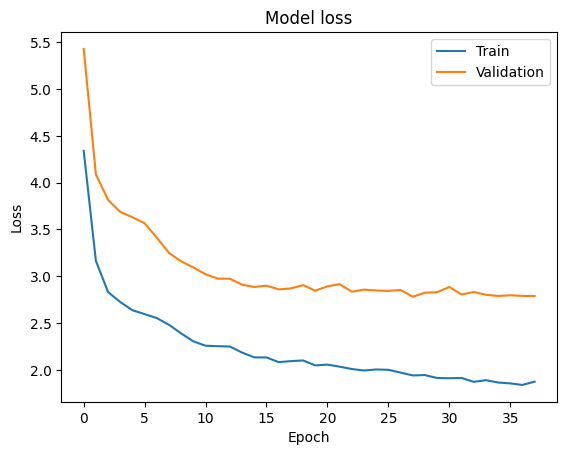

73/73 [==============================] - 1s 5ms/step


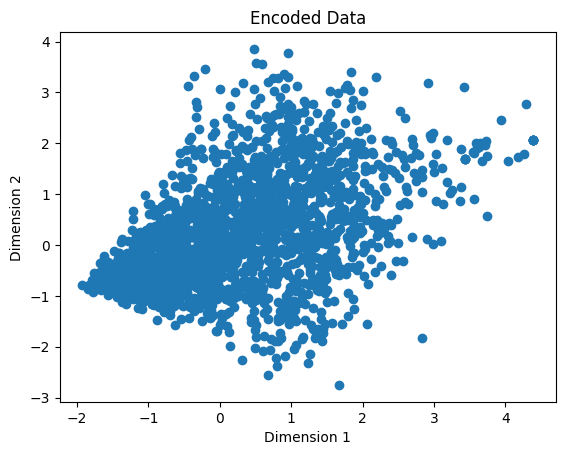

In [276]:
# Normalize the data
data_mean = np.mean(data)
data_std = np.std(data)
data_normalized = (data - data_mean) / data_std

# Create sequences/windows
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)


## Example: Split into training and testing data (optional)
train_size = int(0.8 * num_sequences)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]


# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   # Dimensionality of the input data
latent_dim = 2  # Dimensionality of the latent space
intermediate_dim = 128
dropout_rate = 0.2

# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(intermediate_dim, return_sequences=False,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = Dense(intermediate_dim, activation='relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_repeat = RepeatVector(timesteps)
decoder_lstm = LSTM(intermediate_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))


h_decoded = decoder_repeat(z)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)


# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.15*kl_loss)
vae.add_loss(vae_loss)

# Compile model
#vae.compile(optimizer='rmsprop')
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)
vae.summary()

X_train = sequences

# Train the VAE
#vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)


# Train the VAE with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = vae.fit(X_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(X_train)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data")
plt.show()


# Extract latent representations and reconstructed sequences
#reconstructed_sequences = vae.predict(X_train)

73/73 [==============================] - 1s 5ms/step


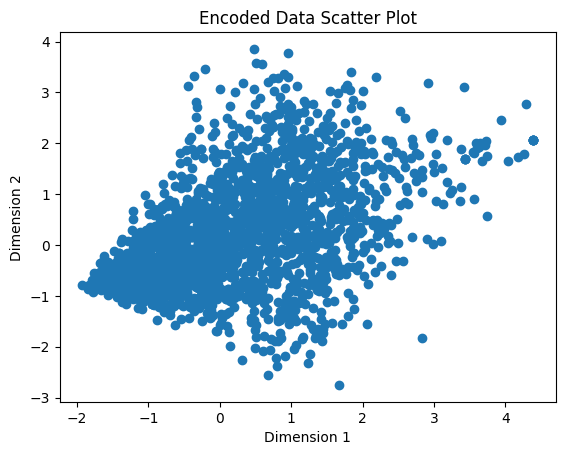

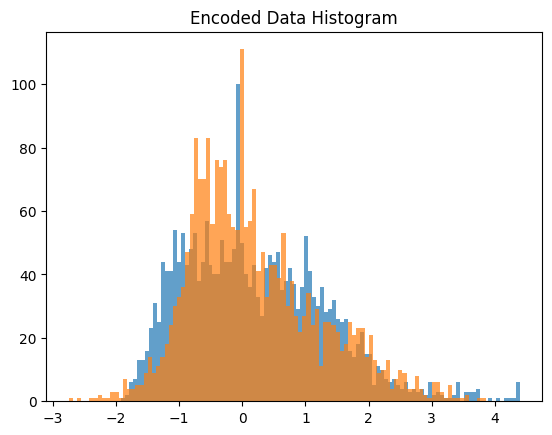

73/73 [==============================] - 2s 8ms/step


In [277]:
# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(X_train)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data Scatter Plot")
plt.show()

plt.hist(encoded_data[:, 0], bins=100, alpha=0.7, label='Feature 1')
plt.hist(encoded_data[:, 1], bins=100, alpha=0.7, label='Feature 2')
plt.title("Encoded Data Histogram")
plt.show()

# Extract latent representations and reconstructed sequences
reconstructed_sequences = vae.predict(X_train)

(2318, 1)
(2318, 1)


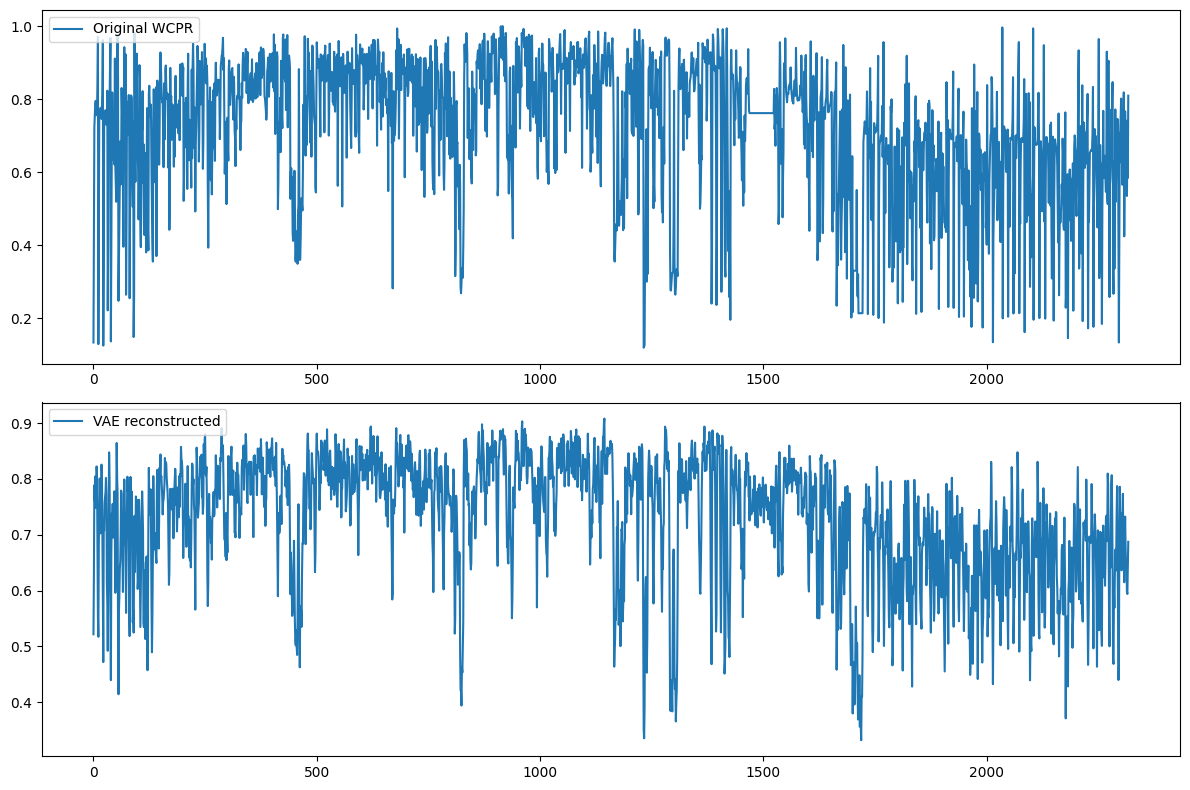

In [278]:
# Plot original vs. reconstructed time series
#(reconstructed_sequences * data_std) + data_mean

# 1. Reshape sequences back to original form
original_shape = (len(data_normalized), 1)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(num_sequences):
    reconstructed_original_data[i:i + timesteps] = sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


reconstructed_original_data_no_norm = (reconstructed_original_data * data_std) + data_mean
reconstructed_vae_data_no_norm = (reconstructed_vae_data * data_std) + data_mean

print(reconstructed_original_data_no_norm.shape)
print(reconstructed_vae_data_no_norm.shape)

temp_cleaned['original'] = reconstructed_original_data_no_norm
temp_cleaned['vae_constructed'] = reconstructed_vae_data_no_norm


# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(temp_cleaned['original'], label='Original WCPR')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(temp_cleaned['vae_constructed'], label='VAE reconstructed')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()